# NFL 2020 Forecasting Yards Gained

> “The running back takes the handoff… he breaks a tackle…spins… and breaks free! One man to beat! Past the 50-yard-line! To the 40! The 30! He! Could! Go! All! The! Way!”

But will he?

American football is a complex sport. From the 22 players on the field to specific characteristics that ebb and flow throughout the game, it can be challenging to quantify the value of specific plays and actions within a play. Fundamentally, the goal of football is for the offense to run (rush) or throw (pass) the ball to gain yards, moving towards, then across, the opposing team’s side of the field in order to score. And the goal of the defense is to prevent the offensive team from scoring.

In the National Football League (NFL), roughly a third of teams’ offensive yardage comes from run plays. Ball carriers are generally assigned the most credit for these plays, but their teammates (by way of blocking), coach (by way of play call), and the opposing defense also play a critical role. Traditional metrics such as ‘yards per carry’ or ‘total rushing yards’ can be flawed; in this competition, the NFL aims to provide better context into what contributes to a successful run play.

As an “armchair quarterback” watching the game, you may think you can predict the result of a play when a ball carrier takes the handoff - but what does the data say? Deeper insight into rushing plays will help teams, media, and fans better understand the skill of players and the strategies of coaches. It will also assist the NFL and its teams evaluate the ball carrier, his teammates, his coach, and the opposing defense, in order to make adjustments as necessary.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from modeling import *
import catboost as cb
import pickle
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
%load_ext autoreload
%autoreload 2

## Data Preprocessing

In [2]:
cols = list(pd.read_csv('Data/cleaned_nfl.csv', nrows=1))
nfl = pd.read_csv('Data/cleaned_nfl.csv',
                  usecols =[i for i in cols if i != 'Yards'])
nfl

,Team,long_axis,short_axis,speed,accel,Dis,Orientation,Dir,DisplayName,Season,...,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,TeamAbbr,OppTeamAbbr,Yard_class
0,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,Eric Berry,2017,...,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE,> 6
1,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,Allen Bailey,2017,...,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE,> 6
2,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,Justin Houston,2017,...,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE,> 6
3,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,Derrick Johnson,2017,...,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE,> 6
4,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,Ron Parker,2017,...,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE,> 6
5,away,75.06,24.00,1.01,0.32,0.18,308.34,95.01,Dee Ford,2017,...,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE,> 6
6,away,74.11,16.64,1.11,0.83,0.02,357.23,322.59,Terrance Mitchell,2017,...,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE,> 6
7,away,73.37,18.73,1.24,0.74,0.13,328.52,270.04,Phillip Gaines,2017,...,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE,> 6
8,away,56.63,26.90,0.26,1.86,0.28,344.70,55.31,Daniel Sorensen,2017,...,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE,> 6
9,away,73.35,38.83,4.55,0.76,0.51,75.47,190.84,Marcus Peters,2017,...,Outdoor,Artificial,Clear,63.0,77.0,8.0,sw,KC,NE,> 6


In [3]:
nfl['Defenders_vs_Distance'] = nfl['DefendersInTheBox'] / nfl['Distance']

## Random Forest Classifier

In [5]:
X = nfl.drop('Yard_class', axis=1)
y = nfl['Yard_class']

for col in X.columns():
    le = LabelEncoder()
    le.fit(list(X[col].astype(str).values))
    X[col] = le.transform(list(X[col].astype(str).values))

X = pd.get_dummies(X, drop_first=True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=220)

## Multiple Linear Regression

In [65]:
linreg = LinearRegression().fit(X_train, y_train)
pickle.dump(linreg, open('Models/linreg.sav', 'wb'))

In [66]:
linreg = pickle.load(open('Models/linreg.sav', 'rb'))
print('Model Score:', linreg.score(X_train, y_train))
print('Intercept:', linreg.intercept_)
print('Coefficients:', linreg.coef_)

Model Score: 0.02936994299337581
Intercept: -670.9833877118408
Coefficients: [-2.68888842e-04  9.86681768e-05 -1.62633126e-01 ...  1.00113992e-01
  7.04155825e-02  2.00321637e-01]


In [67]:
linreg_ols = sm.OLS(y_train,
                    sm.add_constant(X_train)).fit()

In [68]:
model_sum = linreg_ols.summary()
print(model_sum)

                            OLS Regression Results                            
Dep. Variable:                  Yards   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     5.037
Date:                Sun, 24 Nov 2019   Prob (F-statistic):               0.00
Time:                        00:32:03   Log-Likelihood:            -1.3321e+06
No. Observations:              407809   AIC:                         2.669e+06
Df Residuals:                  405369   BIC:                         2.696e+06
Df Model:                        2439                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [69]:
# Create a dataframe from our regression results
lin_table = linreg_ols.summary().tables[1]
lin_table = pd.DataFrame(lin_table.data)
lin_table.columns = lin_table.iloc[0]
lin_table.drop(0, inplace=True)
lin_table = lin_table.set_index(lin_table.columns[0])
lin_table = lin_table.astype(float)
lin_table

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
const,-670.148500,97.230000,-6.892,0.000,-860.715000,-479.582000
long_axis,-0.000300,0.000000,-0.676,0.499,-0.001000,0.001000
short_axis,0.000100,0.001000,0.077,0.938,-0.003000,0.003000
speed,-0.162600,0.022000,-7.376,0.000,-0.206000,-0.119000
accel,0.100300,0.012000,8.529,0.000,0.077000,0.123000
Dis,0.870000,0.202000,4.298,0.000,0.473000,1.267000
Orientation,0.000050,0.000097,0.516,0.606,-0.000000,0.000000
Dir,0.000049,0.000096,0.511,0.609,-0.000000,0.000000
Season,0.365700,0.026000,14.295,0.000,0.316000,0.416000


In [71]:
lin_table.to_csv('Models/linreg.csv')

In [16]:
lin_table = pd.read_csv('Models/linreg.csv')
lin_table.rename(columns={'Unnamed: 0': 'features'},
                 inplace=True)

In [24]:
lin_table = lin_table.set_index('features')

# Get a list of significant variables
significant_vars = list(lin_table.loc[lin_table['P>|t|']
                                      < .05].index)

# Remove intercept if it's in list
if 'intercept' in significant_vars:
    significant_vars.remove('intercept')

    # Sort by magnitude of coefficients for significant values
lin_table['coef_abs'] = abs(lin_table['coef'])
lin_table = lin_table.loc[lin_table['P>|t|']
                          < 0.05, ].sort_values(by='coef_abs',
                                                ascending=False)

In [27]:
X_train = X_train[list(lin_table.index)[1:]]

linreg_ols_2 = sm.OLS(y_train,
                      sm.add_constant(X_train)).fit()
model2_sum = linreg_ols_2.summary()
print(model2_sum)

                            OLS Regression Results                            
Dep. Variable:                  Yards   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     25.34
Date:                Fri, 22 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:31:25   Log-Likelihood:            -1.3332e+06
No. Observations:              407809   AIC:                         2.667e+06
Df Residuals:                  407410   BIC:                         2.672e+06
Df Model:                         398                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

```
model_poly = Pipeline([('scaler', StandardScaler()),
                      ('poly', PolynomialFeatures()),
                      ('linreg', LinearRegression())])

model_poly.fit(X_train, y_train)

print('Model Score:', model_poly.score(X_train, y_train))
print('Intercept:', model_poly.intercept_)
print('Coefficients:', model_poly.coef_)
```

## Lasso

In [76]:
lin_l1 = LassoCV(cv=5, random_state=220)
lin_l1.fit(X_train, y_train)

pickle.dump(lin_l1, open('Models/lasso.sav', 'wb'))

In [77]:
lin_l1 = pickle.load(open('Models/lasso.sav', 'rb'))

print('Model Score:', lin_l1.score(X_train, y_train))
print('Intercept:', lin_l1.intercept_)
print('Coefficients:', lin_l1.coef_)

Model Score: 0.017401557078442043
Intercept: -447.52586372894166
Coefficients: [-0.00020422 -0.         -0.02233492 ... -0.         -0.
  0.        ]


## Ridge

In [78]:
lin_l2 = RidgeCV()
lin_l2.fit(X_train, y_train)

pickle.dump(lin_l2, open('Models/ridge.sav', 'wb'))

In [79]:
lin_l2 = pickle.load(open('Models/ridge.sav', 'rb'))

print('Model Score:', lin_l2.score(X_train, y_train))
print('Intercept:', lin_l2.intercept_)
print('Coefficients:', lin_l2.coef_)

Model Score: 0.028868386879902008
Intercept: -735.5834067898729
Coefficients: [-2.77222703e-04  1.15300049e-04 -1.60641269e-01 ...  9.44893320e-02
  7.29560736e-02  2.00470512e-01]


## Random Forest Regressor

In [5]:
for col in nfl.columns:
    if nfl[col].dtype == 'O':
        item_count = dict(nfl[col].value_counts())
        nfl[col] = nfl[col].apply(lambda x: item_count[x])
        
nfl.to_csv('Data/nfl_rf.csv', index=False)

In [5]:
nfl_rf = pd.read_csv('Data/nfl_rf.csv')
nfl_rf.head()

,Team,long_axis,short_axis,speed,accel,Dis,Orientation,Dir,DisplayName,Season,...,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,TeamAbbr,OppTeamAbbr,Defenders_vs_Distance
0,254881,73.91,34.84,1.69,1.13,0.40,81.99,177.18,72,2017,...,392106,212168,51304,63.0,77.0,8.0,82896,15598,16379,3.0
1,254881,74.67,32.64,0.42,1.35,0.01,27.61,198.70,460,2017,...,392106,212168,51304,63.0,77.0,8.0,82896,15598,16379,3.0
2,254881,74.00,33.20,1.22,0.59,0.31,3.01,202.73,571,2017,...,392106,212168,51304,63.0,77.0,8.0,82896,15598,16379,3.0
3,254881,71.46,27.70,0.42,0.54,0.02,359.77,105.64,336,2017,...,392106,212168,51304,63.0,77.0,8.0,82896,15598,16379,3.0
4,254881,69.32,35.42,1.82,2.43,0.16,12.63,164.31,674,2017,...,392106,212168,51304,63.0,77.0,8.0,82896,15598,16379,3.0


In [6]:
X = nfl_rf.drop('Yards', axis=1)
y = nfl_rf['Yards']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=220)

In [9]:
rf = RandomForestRegressor(max_depth=10, n_estimators=100)
rf.fit(X_train, y_train)

pickle.dump(rf, open('Models/rf.sav', 'wb'))

In [10]:
rf = pickle.load(open('Models/rf.sav', 'rb'))

print('Model Score:', rf.score(X_train, y_train))

Model Score: 0.2296833827177036


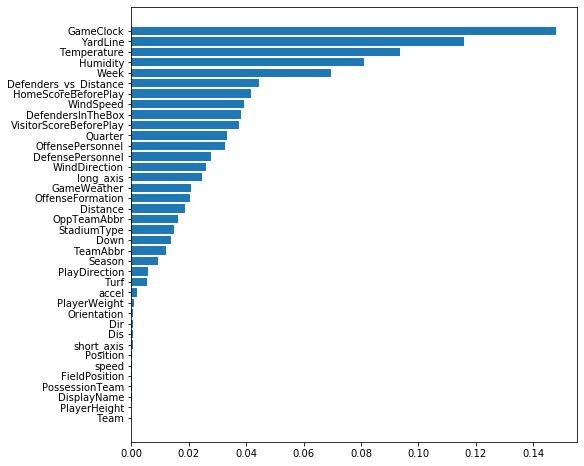

In [44]:
feat_imp = pd.DataFrame([X.columns.values, rf.feature_importances_]).T
feat_imp.columns=['features', 'importance']
feat_imp.sort_values(by='importance', inplace=True)
plt.figure(figsize=(8, 8))
plt.barh(feat_imp['features'], feat_imp['importance'], align='center');

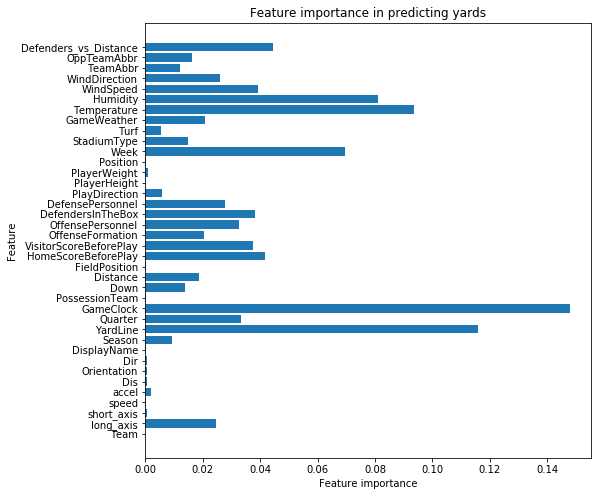

In [22]:
plt.figure(figsize=(8, 8))
n_features = X.shape[1]
plt.barh(range(n_features),
         rf.feature_importances_,
         align='center')
plt.yticks(np.arange(n_features), X.columns.values)
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.title('Feature importance in predicting yards');

## XGBoost Regressor

In [ ]:
param_xg = {"learning_rate": [0.01, 0.05, 0.1],
            'max_depth': [2, 3, 4],
            'n_estimators': [140, 150, 160]}

gs_boost = run_randomized_search(xgb.XGBRegressor, param_xg,
                                 X_train, X_test,
                                 y_train, y_test, random_state=220)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


## SVM Regressor

In [7]:
scale = StandardScaler()

X_train_scale = scale.fit_transform(X_train)
X_test_scale = scale.transform(X_test)

In [ ]:
svm = SVR(kernel='rbf', C=0.655)
svm.fit(X_train_scale, y_train)

pickle.dump(svm, open('Models/svm.sav', 'wb'))

In [ ]:
svm = pickle.load(open('Models/svm.sav', 'rb'))

print('Model Score:', svm.score(X_train_scale, y_train))
print('Intercept:', svm.intercept_)
print('Coefficients:', svm.coef_)